In [3]:


from langchain_openai import AzureChatOpenAI, ChatOpenAI
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
from langgraph.graph import START, StateGraph, MessagesState, END
from typing_extensions import List, TypedDict
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.tools import tool
from langchain.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition
from IPython.display import Image, display
from dotenv import load_dotenv
import os

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [4]:
load_dotenv(override=True)

True

In [5]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [6]:
# Load and chunk contents of the blog
pdf_data_path = "example_data"
loader = DirectoryLoader(pdf_data_path, glob="*.pdf", loader_cls=PyPDFLoader)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)
len(all_splits)


27

In [7]:
# embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = InMemoryVectorStore(embedding_model)

C:\Users\HLC\AppData\Local\Temp\ipykernel_7236\964325612.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


In [8]:
# Index chunks
document_ids = vector_store.add_documents(documents=all_splits)
print(document_ids)

['10798ca9-edc0-49f4-a7a4-f18bfcb6f58a', '60db70e8-13a1-4fb6-b08c-6a96980d0072', '94c8b127-4874-476c-b5b7-bc6dc5fa7237', 'dc71803e-7aab-48e8-8662-236d9a889551', '484acb37-8ecd-473c-a5ed-9d5c52c8fc78', 'c378040f-56bf-4d3a-b11a-5ad1691e84d5', '37aaa3be-fc03-485a-902e-ea96efeb9cad', '8e8f2a69-19c5-4ad1-8d1b-12b573de297c', '9819d30f-289a-41ff-882f-8927ed723ce2', 'ba86c11b-d0e4-452f-9e26-391ba1a6e076', '23849570-79d7-44c5-bd1f-dc54847cd602', '44446671-94f7-4929-a0ca-d31a228b219a', 'fbba10bd-b34d-4d0d-b5d6-e5a12f29e287', 'b706d221-f44b-4952-b4fc-85b2975e0829', 'a9bffff0-e593-49e9-a973-8b2e0f212ff6', '1c832034-1224-4118-b1b6-bc03b6be80f4', '94f9fdbf-a4fe-4589-b8fa-a48f5a7473a6', '2a28fd23-0009-4341-b07c-39432125b66f', 'ce7e9aa1-b120-46d8-aa08-2dfb5f9dbd04', '72efd128-28b5-4008-9d69-67e5e55a4932', 'ab87ebff-273c-4876-9337-d4bd109100e3', '90e1143a-da26-4163-87ed-5df0a22ae816', 'a9607ac4-ef29-40b3-bf2b-80e8464274e4', 'aeb8247b-0478-40c4-8437-243262408f8a', 'd7903fb6-bad5-45f8-8809-2b4f78bfc1bd',

In [9]:
graph_builder = StateGraph(MessagesState)

In [10]:
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [11]:
# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


In [12]:
# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])

In [13]:
# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}


In [14]:
graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

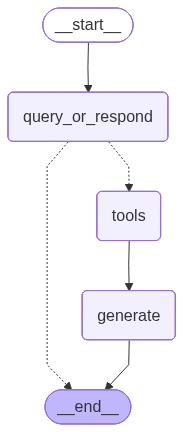

In [15]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
input_message = "What's your name?"

for node_state in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    node_state["messages"][-1].pretty_print()

================================ Human Message =================================

What's your name?
================================== Ai Message ==================================

I don't have a personal name, but you can call me Assistant! How can I help you today?


### Stateful management of chat history

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [18]:
input_message = "What is ReactJS?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is ReactJS?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_rNAb3LWTMCeDOnQdYKqAcQa6)
 Call ID: call_rNAb3LWTMCeDOnQdYKqAcQa6
  Args:
    query: What is ReactJS?
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'xdvipdfmx (20220710)', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-10-03T07:26:44+00:00', 'source': 'example_data\\fe_framework.pdf', 'total_pages': 4, 'page': 0, 'page_label': '1', 'start_index': 0}
Content: Popular Frontend Frameworks and Libraries
in 2025
October 2025
Introduction
In the rapidly evolving world of web development, frontend frameworks and
libraries are essential for building dynamic, responsive user interfaces. As of
2025, the landscape is dominated by established giants and innovative meta-
frameworks. This document explores React, V

In [19]:
input_message = "Can you tell me about the popularity of it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you tell me about the popularity of it?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_z7uiptGXnfXqYs5V3TX18SLP)
 Call ID: call_z7uiptGXnfXqYs5V3TX18SLP
  Args:
    query: ReactJS popularity 2025
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'xdvipdfmx (20220710)', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-10-03T07:26:44+00:00', 'source': 'example_data\\fe_framework.pdf', 'total_pages': 4, 'page': 2, 'page_label': '3', 'start_index': 0}
Content: 2 Popularity Comparison
Popularity is measured using GitHub stars, NPM downloads, and the State of
JavaScript 2024 survey, reflecting trends as of mid-2025.
Framework GitHub Stars Weekly NPM Downloads (M)Usage % Retention %
React 220,000 25+ 63% 81%
Vue.js 42,000 6.6 43% 85%
Angular 91,000 3.5 18% 62%
Next.js 120,